# Binning LRAUV Data

Classification output (inference) is matched to the LRAUV data at the `inference_out/lrauv_april2025_with_class.parquet` file. Thata file was generated in the `synchro-Apr2025-planktivore-occurance-high-mag-bytime.ipynb` notebook.

- This data is loaded into a `pandas dataframe` and run through the binning function: `bin_casts_avg_with_time_updown`.
    - Parameters for binning can be set here.

In [48]:
from typing import Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
import gsw
fig_dir=Path("c:/planktivore/figures/")
#fig_dir = Path("../../figures")
p=Path("c:/planktivore/")
#p = Path("../../inference_out/")

In [52]:
def bin_casts_avg_with_time_updown(
    df: pd.DataFrame,
    depth_col: str = "depth",
    cast_col: str = "cast_id",
    time_col: Optional[str] = None,    # if None, use datetime index
    bin_size: float = 1.0,
    phase_labels: Tuple[str, str] = ("down", "up"),
    smooth_window: int = 15,            # samples (rolling median) to stabilize direction
    closed: str = "right",             # Interval closure for pd.cut
    per_phase_edges: bool = False,     # if True, compute bin edges separately for up/down
) -> pd.DataFrame:
    """
    For each cast, split trajectory into down/up phases, bin by depth, and compute:
      - numeric means per bin,
      - start_time, end_time (first/last timestamps observed in the bin),
      - elapsed_seconds (sum of dt while consecutive samples stay in the same bin),
      - rep_timestamp (timestamp of sample closest to bin center).

    Returns a tidy DataFrame indexed by [cast_id, phase, depth_bin_center].
    """
    def custom_sum_with_min_counter(series):
        return series.sum(min_count=1)

    # ---- Prep time column ----
    work = df.copy()
    if time_col is None:
        if not np.issubdtype(work.index.dtype, np.datetime64):
            raise ValueError("time_col is None but index is not datetime-like.")
        work["__time__"] = work.index
        time_col = "__time__"
    else:
        if not np.issubdtype(work[time_col].dtype, np.datetime64):
            work[time_col] = pd.to_datetime(work[time_col])

    # ---- Basic checks ----
    for c in (cast_col, depth_col, time_col):
        if c not in work.columns:
            raise ValueError(f"Missing required column: {c}")

    # The code below removes NaNs but we don't want them to become zeros.  We want NaNs
    ## ---- Clean & sort ----
    #work = (
    #    work.dropna(subset=[cast_col, depth_col, time_col])
    #        .sort_values([cast_col, time_col])
    #)

    out_frames = []

    # ---- Process each cast ----
    for cid, g_cast in work.groupby(cast_col, sort=True):
        # Ensure numeric columns are float64 for proper NaN handling
        numerical_cols=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'cast_id',
       'cast_id_unique', 'distance_km', 'rois_count', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen',
       'Gyrodinium', 'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain',
       'Nano_plankton', 'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia',
       'Strombidium', 'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate','Akashiwo_rate', 'Amphidinium_Oxyphysis_rate',
       'Ceratium_rate', 'Chaetoceros_rate', 'Ciliate_rate',
       'Cylindrotheca_rate', 'Detonula_Cerataulina_Lauderia_rate',
       'Detritus_rate', 'Dictyocha_rate', 'Dinoflagellate_rate',
       'Eucampia_rate', 'Guinardia_Dactyliosolen_rate', 'Gyrodinium_rate',
       'Medium_pennate_rate', 'Mesodinium_rate', 'Mixed_diatom_chain_rate',
       'Nano_plankton_rate', 'Polykrikos_rate', 'Prorocentrum_rate',
       'Pseudo-nitzschia_rate', 'Strombidium_rate', 'Thalassionema_rate',
       'Thalassiosira_rate', 'Tiarina_rate', 'Truncated_rate',
       'unknown_flagellate_rate']
        g_cast[numerical_cols]=g_cast[numerical_cols].astype('float64')
        # end of new code

        g_cast = g_cast.sort_values(time_col).copy()

        # Direction: positive depth change => down; negative => up
        ddepth = g_cast[depth_col].diff()
        if smooth_window and smooth_window > 1:
            ddepth = ddepth.rolling(smooth_window, center=True, min_periods=1).median()

        sign = np.sign(ddepth).replace({0: np.nan})
        sign = sign.ffill().bfill()
        phase_map = {1.0: phase_labels[0], -1.0: phase_labels[1]}
        g_cast["phase"] = sign.map(phase_map)

        if g_cast["phase"].isna().all():
        #    # Degenerate (flat) cast — skip
            continue

        # Bin edges (shared across phases for this cast unless per_phase_edges=True)
        def make_edges(g):
            # we need to specify that bin is a certain value.
            # old code:
            #dmin = float(np.floor(g[depth_col].min()))
            #dmax = float(np.ceil(g[depth_col].max()))
            dmin = float(np.floor(g[depth_col].min()/bin_size)*bin_size)
            dmax = float(np.ceil(g[depth_col].max()/bin_size)*bin_size)
            edges = np.arange(dmin, dmax + bin_size, bin_size)
            return edges if edges.size >= 2 else None

        shared_edges = make_edges(g_cast) if not per_phase_edges else None
        if not per_phase_edges and shared_edges is None:
            continue

        # ---- Process each phase ----
        for ph, gp in g_cast.groupby("phase", sort=True):
            if gp.empty:
                continue

            edges = make_edges(gp) if per_phase_edges else shared_edges
            if edges is None:
                continue

            ivals = pd.IntervalIndex.from_breaks(edges, closed=closed)

            gg = gp.sort_values(time_col).copy()
            gg["_bin"] = pd.cut(gg[depth_col], bins=ivals)
            #
            # New aggregation logic
            # add code for aggregation_columns
            aggregation_columns = [col for col in gg.columns if col not in [cast_col, time_col, depth_col, "phase", "_bin"]]

            keywords=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
            'mass_concentration_of_oxygen_in_sea_water',
            'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
            'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
            'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
            'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
            'particulatebackscatteringcoeff470nm',
            'particulatebackscatteringcoeff650nm',
            'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
            'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
            'cast_id_unique', 'distance_km']
            # do we need other keywords?  Do we want to add rois_count and the species rates?
            
            agg_dict = {}
            for col in aggregation_columns:
                col_lower=col.lower()
                if any(keyword in col_lower for keyword in keywords):
                    agg_dict[col] = 'mean'
                else:
                    agg_dict[col] = custom_sum_with_min_counter
                    #agg_dict[col] = 'sum'

            # Numeric means per observed bin
            # why do we use a mean here and not the sum?
            agg= gg.groupby("_bin", observed=True).agg(agg_dict)
            #
            # end of new code
            #
            # old code:
            #agg = gg.groupby("_bin", observed=True).mean(numeric_only=True)
            if agg.empty:
                continue

            # Bin center
            bin_center_col = f"{depth_col}_bin_center"
            agg[bin_center_col] = [iv.mid for iv in agg.index]
            agg[cast_col] = cid
            agg["phase"] = ph

            # Representative timestamp: nearest to bin center within phase subset
            rep_times = []
            for iv in agg.index:
                sub = gg.loc[gg["_bin"] == iv]
                if sub.empty:
                    rep_times.append(pd.NaT)
                    continue
                mid = iv.mid
                idx = (sub[depth_col] - mid).abs().idxmin()
                rep_times.append(gg.loc[idx, time_col])
            agg["rep_timestamp"] = pd.to_datetime(rep_times)

            # --- Time-in-bin: sum dt where next sample remains in the same bin ---
            gs = gg.copy()
            gs["__next_time__"] = gs[time_col].shift(-1)
            gs["__next_bin__"] = gs["_bin"].shift(-1)
            # original line:
            mask = gs["_bin"].notna() & (gs["_bin"] == gs["__next_bin__"])
            #mask = gs["_bin"] == gs["__next_bin__"]
            dt = (gs.loc[mask, "__next_time__"] - gs.loc[mask, time_col]).dt.total_seconds()
            elapsed = dt.groupby(gs.loc[mask, "_bin"], observed=True).sum(min_count=1)
            
            elapsed = elapsed.reindex(agg.index)  # align to bins present in agg

            # Start/end times per bin (first/last timestamps observed in that bin)
            ts_first = gg.groupby("_bin", observed=True)[time_col].first().reindex(agg.index)
            ts_last  = gg.groupby("_bin", observed=True)[time_col].last().reindex(agg.index)

            agg["start_time"] = pd.to_datetime(ts_first.values)
            agg["end_time"] = pd.to_datetime(ts_last.values)
            agg["elapsed_seconds"]=elapsed.astype(float)
            # Supposedly this line gets rid of all NaNs but we need to keep them and true zeros
            #agg["elapsed_seconds"] = elapsed.fillna(0.0).astype(float)

            out_frames.append(agg.reset_index(drop=True))

    if not out_frames:
        cols = [cast_col, "phase", f"{depth_col}_bin_center", "rep_timestamp", "start_time", "end_time", "elapsed_seconds"]
        return pd.DataFrame(columns=cols).set_index([cast_col, "phase", f"{depth_col}_bin_center"])

    result = (
        pd.concat(out_frames, ignore_index=True)
          .set_index([cast_col, "phase", f"{depth_col}_bin_center"])
          .sort_index()
    )
    return result

In [49]:
#df = pd.read_parquet(p / "lrauv_april2025_with_class.parquet")
#df = pd.read_parquet(p / "lrauv_april2025_with_class_20251009model_filtered.parquet")
df = pd.read_parquet(p / "lrauv_april2025_with_class_20251009model_filtered_addNaN_update.parquet")
#df=pd.read_parquet(p / "inference_results_mbari-ptvr-vits-b8-20250826_synchro_202504.parquet")

In [50]:
df.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km', 'rois_count', 'highmag_detections',
       'highmag_rois', 'highmag_saved_rois', 'highmag_average_area',
       'rois_norm', 'Akashiwo', 'Amphidinium_Oxyphysis', 'Ceratium',
       'Chaetoceros', 'Ciliate', 'Cylindrotheca',
       'Detonula_Cerataulina_Lauderia', 'Detritus', 'Dictyocha',
       'Dinoflagellate'

In [51]:
df[['Dinoflagellate','Dinoflagellate_rate']].iloc[2000:2010]

,Dinoflagellate,Dinoflagellate_rate
time,,
2025-04-14 22:40:54,0.0,0.0
2025-04-14 22:40:56,0.0,0.0
2025-04-14 22:40:58,0.0,0.0
2025-04-14 22:41:00,0.0,0.0
2025-04-14 22:41:02,0.0,0.0
2025-04-14 22:41:04,0.0,0.0
2025-04-14 22:41:06,1.0,0.5
2025-04-14 22:41:08,0.0,0.0
2025-04-14 22:41:10,1.0,0.5


In [53]:
cols_to_bin = ['Akashiwo', 'Amphidinium_Oxyphysis', 'Ceratium',
       'Chaetoceros', 'Ciliate', 'Cylindrotheca',
       'Detonula_Cerataulina_Lauderia', 'Detritus', 'Dictyocha',
       'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen', 'Gyrodinium',
       'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain', 'Nano_plankton',
       'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia', 'Strombidium',
       'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate', 'Akashiwo_rate', 'Amphidinium_Oxyphysis_rate',
       'Ceratium_rate', 'Chaetoceros_rate', 'Ciliate_rate',
       'Cylindrotheca_rate', 'Detonula_Cerataulina_Lauderia_rate',
       'Detritus_rate', 'Dictyocha_rate', 'Dinoflagellate_rate',
       'Eucampia_rate', 'Guinardia_Dactyliosolen_rate', 'Gyrodinium_rate',
       'Medium_pennate_rate', 'Mesodinium_rate', 'Mixed_diatom_chain_rate',
       'Nano_plankton_rate', 'Polykrikos_rate', 'Prorocentrum_rate',
       'Pseudo-nitzschia_rate', 'Strombidium_rate', 'Thalassionema_rate',
       'Thalassiosira_rate', 'Tiarina_rate', 'Truncated_rate',
       'unknown_flagellate_rate']
mask=df['rois_count'].isna()
df.loc[mask, cols_to_bin]=np.nan

In [26]:
#df[['rois_count','Akashiwo']].iloc[100:110]

In [27]:
#df.keys()

In [54]:
ll=df['cast_id']==1
cast_col='cast_id'
depth_col='depth'
time_col=None
bin_size=5
smooth_window=5
phase_labels=["down", "up"]
closed='right'
per_phase_edges: bool = False
work = df.copy()
work=work[ll]
def custom_sum_with_min_counter(series):
    return series.sum(min_count=1)
if time_col is None:
    if not np.issubdtype(work.index.dtype, np.datetime64):
        raise ValueError("time_col is None but index is not datetime-like.")
    work["__time__"] = work.index
    time_col = "__time__"
else:
    if not np.issubdtype(work[time_col].dtype, np.datetime64):
        work[time_col] = pd.to_datetime(work[time_col])

    # ---- Basic checks ----
for c in (cast_col, depth_col, time_col):
    if c not in work.columns:
        raise ValueError(f"Missing required column: {c}")
    out_frames = []

# ---- Process each cast ----
for cid, g_cast in work.groupby(cast_col, sort=True):
    numerical_cols=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'cast_id',
       'cast_id_unique', 'distance_km', 'rois_count', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen',
       'Gyrodinium', 'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain',
       'Nano_plankton', 'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia',
       'Strombidium', 'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate','Akashiwo_rate', 'Amphidinium_Oxyphysis_rate',
       'Ceratium_rate', 'Chaetoceros_rate', 'Ciliate_rate',
       'Cylindrotheca_rate', 'Detonula_Cerataulina_Lauderia_rate',
       'Detritus_rate', 'Dictyocha_rate', 'Dinoflagellate_rate',
       'Eucampia_rate', 'Guinardia_Dactyliosolen_rate', 'Gyrodinium_rate',
       'Medium_pennate_rate', 'Mesodinium_rate', 'Mixed_diatom_chain_rate',
       'Nano_plankton_rate', 'Polykrikos_rate', 'Prorocentrum_rate',
       'Pseudo-nitzschia_rate', 'Strombidium_rate', 'Thalassionema_rate',
       'Thalassiosira_rate', 'Tiarina_rate', 'Truncated_rate',
       'unknown_flagellate_rate']
    g_cast[numerical_cols]=g_cast[numerical_cols].astype('float64')
    g_cast = g_cast.sort_values(time_col).copy()
    # Direction: positive depth change => down; negative => up
    ddepth = g_cast[depth_col].diff()
    if smooth_window and smooth_window > 1:
        ddepth = ddepth.rolling(smooth_window, center=True, min_periods=1).median()
        sign = np.sign(ddepth).replace({0: np.nan})
        sign = sign.ffill().bfill()
        phase_map = {1.0: phase_labels[0], -1.0: phase_labels[1]}
        g_cast["phase"] = sign.map(phase_map)
    def make_edges(g):
        dmin = float(np.floor(g[depth_col].min()/bin_size)*bin_size)
        dmax = float(np.ceil(g[depth_col].max()/bin_size)*bin_size)
        edges = np.arange(dmin, dmax + bin_size, bin_size)
        return edges if edges.size >= 2 else None

    shared_edges = make_edges(g_cast) if not per_phase_edges else None
    if not per_phase_edges and shared_edges is None:
        continue
    for ph, gp in g_cast.groupby("phase", sort=True):
        if gp.empty:
            continue

        edges = make_edges(gp) if per_phase_edges else shared_edges
        if edges is None:
            continue

        ivals = pd.IntervalIndex.from_breaks(edges, closed=closed)

        gg = gp.sort_values(time_col).copy()
        # new force data to be float
        #gg=gg.astype('float64')
        #
        gg["_bin"] = pd.cut(gg[depth_col], bins=ivals)
        aggregation_columns = [col for col in gg.columns if col not in [cast_col, time_col, depth_col, "phase", "_bin"]]

        keywords=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
        'mass_concentration_of_oxygen_in_sea_water',
        'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
        'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
        'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
        'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
        'particulatebackscatteringcoeff470nm',
        'particulatebackscatteringcoeff650nm',
        'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
        'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
        'cast_id_unique', 'distance_km']
            # do we need other keywords?  Do we want to add rois_count and the species rates?
            
        agg_dict = {}
        for col in aggregation_columns:
            col_lower=col.lower()
            if any(keyword in col_lower for keyword in keywords):
                agg_dict[col] = 'mean'
            else:
                #agg_dict[col] = 'sum'
                agg_dict[col] = custom_sum_with_min_counter
    
        agg= gg.groupby("_bin", observed=True).agg(agg_dict)
        #
        # end of new code
        #
        # old code:
        ##agg = gg.groupby("_bin", observed=True).mean(numeric_only=True)
        #if agg.empty:
        #    continue

        ## Bin center
        #bin_center_col = f"{depth_col}_bin_center"
        #agg[bin_center_col] = [iv.mid for iv in agg.index]
        #agg[cast_col] = cid
        #agg["phase"] = ph



In [55]:
test=gg.groupby("_bin", observed=True)['rois_count'].sum(min_count=1)

In [56]:
agg_dict

{'fix_latitude': 'mean',
 'fix_longitude': 'mean',
 'salinity': 'mean',
 'temperature': 'mean',
 'mass_concentration_of_oxygen_in_sea_water': 'mean',
 'bin_mean_sea_water_salinity': 'mean',
 'bin_median_sea_water_salinity': 'mean',
 'bin_mean_sea_water_temperature': 'mean',
 'bin_median_sea_water_temperature': 'mean',
 'PAR': <function __main__.custom_sum_with_min_counter(series)>,
 'chlorophyll': 'mean',
 'chl': 'mean',
 'bbp470': 'mean',
 'bbp650': 'mean',
 'volumescatcoeff117deg470nm': 'mean',
 'volumescatcoeff117deg650nm': 'mean',
 'particulatebackscatteringcoeff470nm': 'mean',
 'particulatebackscatteringcoeff650nm': 'mean',
 'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources': <function __main__.custom_sum_with_min_counter(series)>,
 'latitude': 'mean',
 'longitude': 'mean',
 'turning_point': 'mean',
 'cast_id_unique': 'mean',
 'distance_km': 'mean',
 'rois_count': <function __main__.custom_sum_with_min_counter(series)>,
 'highmag_detections': <function

In [31]:
#import xarray as xr
#xf=xr.open_dataset(p / "Ahi_20250414_20250418.nc")
#dlr=xf.to_dataframe()

In [57]:
df.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km', 'rois_count', 'highmag_detections',
       'highmag_rois', 'highmag_saved_rois', 'highmag_average_area',
       'rois_norm', 'Akashiwo', 'Amphidinium_Oxyphysis', 'Ceratium',
       'Chaetoceros', 'Ciliate', 'Cylindrotheca',
       'Detonula_Cerataulina_Lauderia', 'Detritus', 'Dictyocha',
       'Dinoflagellate'

In [58]:
binned = bin_casts_avg_with_time_updown(
    df.reset_index(drop=False),
    depth_col="depth",
    cast_col="cast_id",
    time_col="time",   # or None to use datetime index
    bin_size=10, # changed from 5 to 10 on 2026-01-21
    phase_labels=("down", "up"),
    smooth_window=10, # changed from 5 to 10 on 2026-01-21
#    smooth_window=17,
    closed="right",
    per_phase_edges=True,  # True if you want separate edges for up/down
)
binned = binned.reset_index()
binned['sigma_theta'] = gsw.sigma0(binned['salinity'], binned['temperature'])

In [59]:
print(binned['Dinoflagellate_rate'].iloc[2000:2010])
print(binned['Dinoflagellate'].iloc[2000:2010])

2000    0.5
2001    0.5
2002    1.0
2003    1.5
2004    1.0
2005    0.5
2006    1.5
2007    0.0
2008    0.0
2009    0.0
Name: Dinoflagellate_rate, dtype: float64
2000    1.0
2001    1.0
2002    2.0
2003    3.0
2004    2.0
2005    1.0
2006    3.0
2007    0.0
2008    0.0
2009    0.0
Name: Dinoflagellate, dtype: float64


In [34]:
binned['rois_count']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
8094      NaN
8095      NaN
8096     57.0
8097    135.0
8098     12.0
Name: rois_count, Length: 8099, dtype: float64

In [60]:
binned.to_csv(p / "lrauv_april2025_binned_depthtime_updown_10m_perphase_edges_jan26.csv", index=False) # changed from 5m to 10m

In [36]:
binned.keys()

Index(['cast_id', 'phase', 'depth_bin_center', 'fix_latitude', 'fix_longitude',
       'salinity', 'temperature', 'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'turning_point', 'cast_id_unique',
       'distance_km', 'rois_count', 'highmag_detections', 'highmag_rois',
       'highmag_saved_rois', 'highmag_average_area', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagell

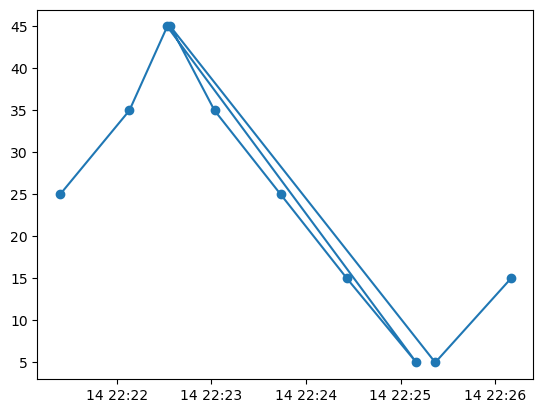

In [37]:
# why do the time values look messed up?
plt.plot(binned['rep_timestamp'][90:100],binned['depth_bin_center'][90:100],'o-')

(20194.402777777777, 20197.0)

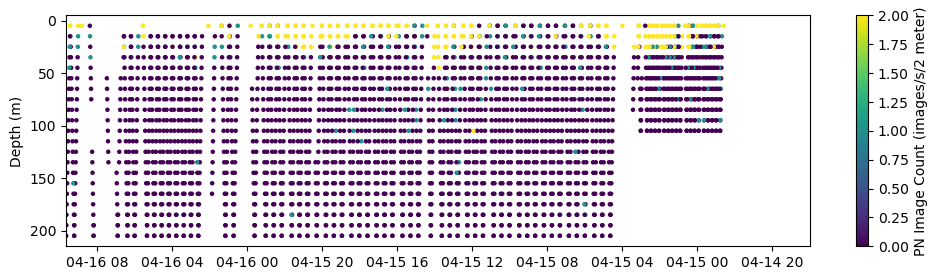

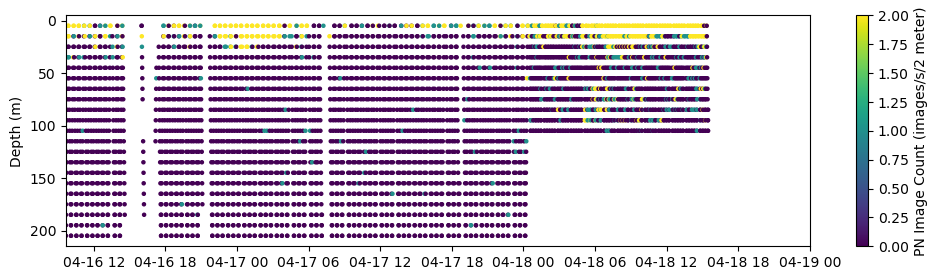

In [38]:
fig1,ax1 = plt.subplots(figsize=(12, 3))
cax1 = ax1.scatter(binned['start_time'], binned['depth_bin_center'],c=binned['Pseudo-nitzschia'],clim=(0,2),s=5)
plt.colorbar(cax1, ax=ax1, label='PN Image Count (images/s/2 meter)')
ax1.invert_yaxis()
#ax1.invert_xaxis()
ax1.set_ylabel('Depth (m)')
ax1.set_xlim(dt.datetime(2025,4,16,9,40),dt.datetime(2025,4,14,18,0,0))
#plt.colorbar(cax1, ax=ax1, label='PN Image Count (images/s/2 meter)')
#plt.savefig(fig_dir / 'April2025_PN_depth_binned_outbound.png', dpi=300, bbox_inches='tight')

#ax1.set_xlim(dt.datetime(2025,4,14,18,0,0),dt.datetime(2025,4,16,9,40))

fig2,ax2 = plt.subplots(figsize=(12, 3))
cax2 = ax2.scatter(binned['start_time'], binned['depth_bin_center'],c=binned['Pseudo-nitzschia'],clim=(0,2),s=5)
plt.colorbar(cax2, ax=ax2, label='PN Image Count (images/s/2 meter)')
ax2.invert_yaxis()
ax2.set_ylabel('Depth (m)')
ax2.set_xlim(dt.datetime(2025,4,16,9,40),dt.datetime(2025,4,19))
#plt.savefig(fig_dir / 'April2025_PN_depth_binned_inbound.png', dpi=300, bbox_inches='tight')


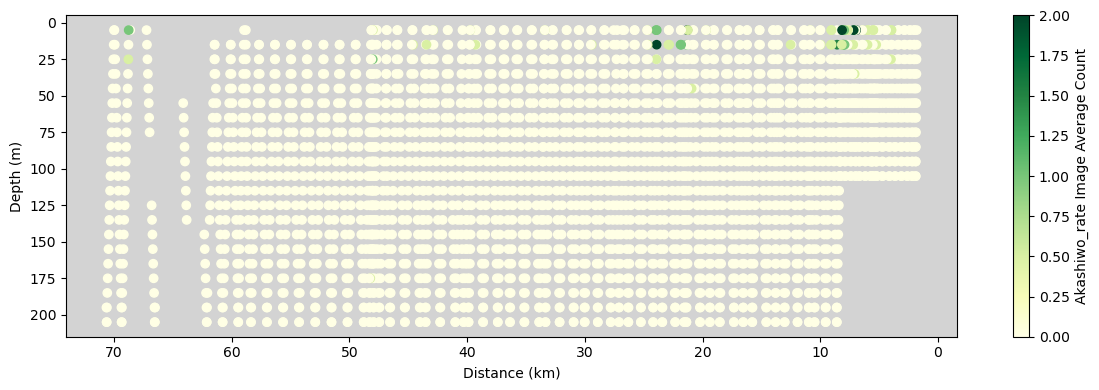

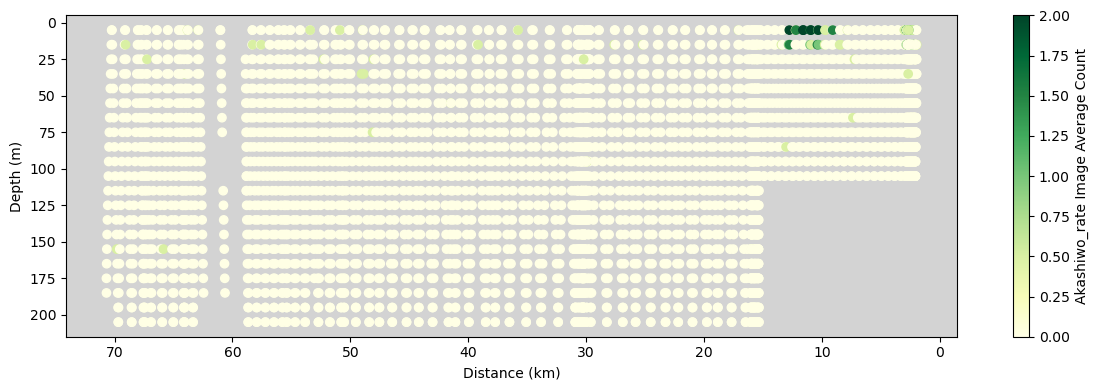

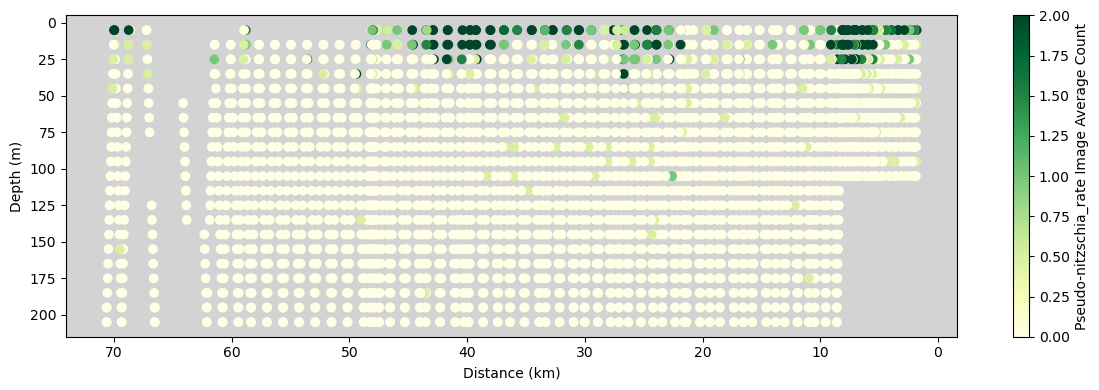

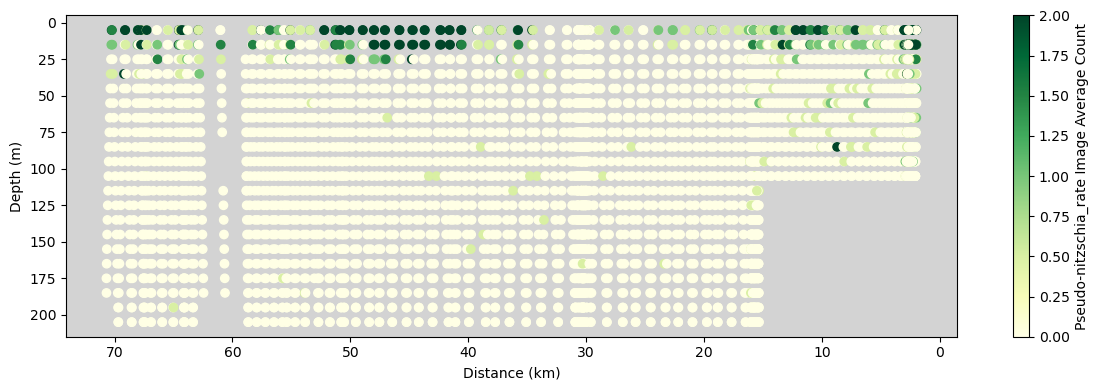

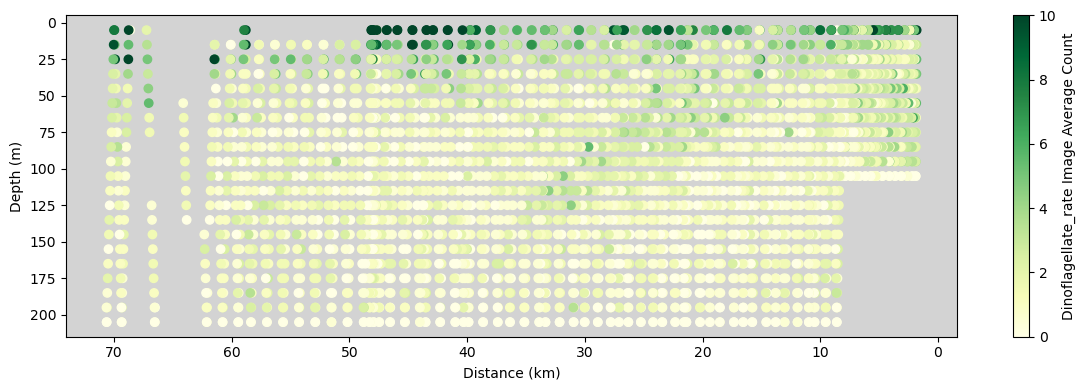

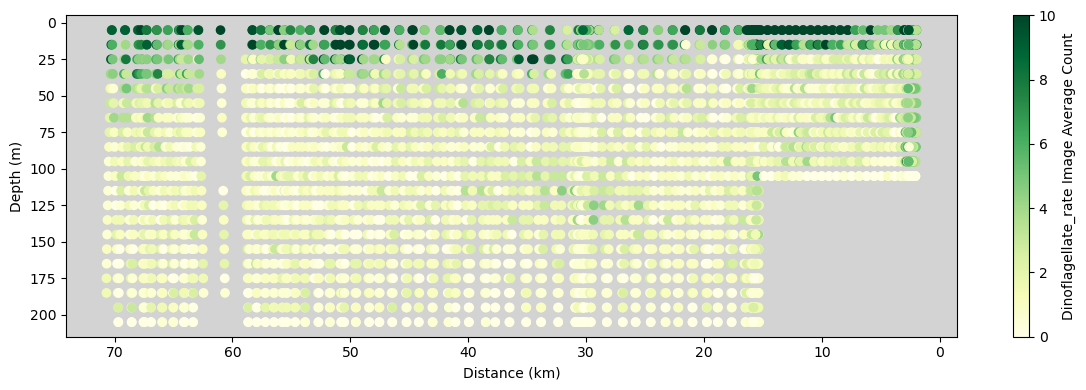

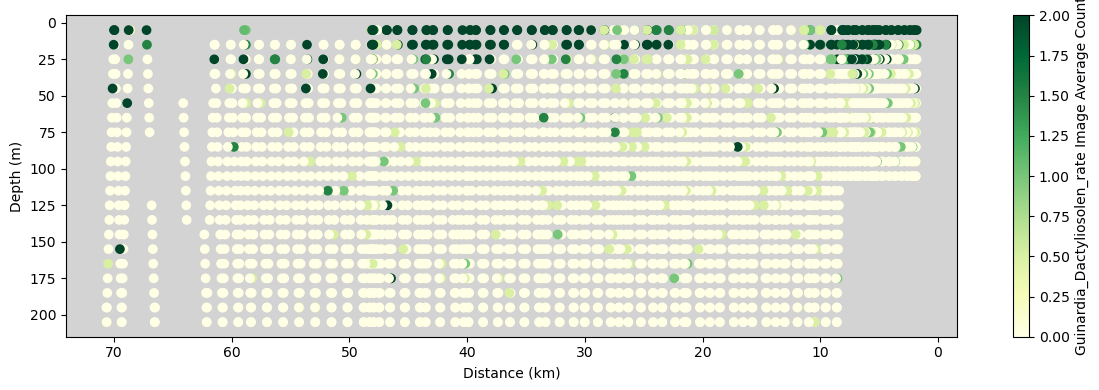

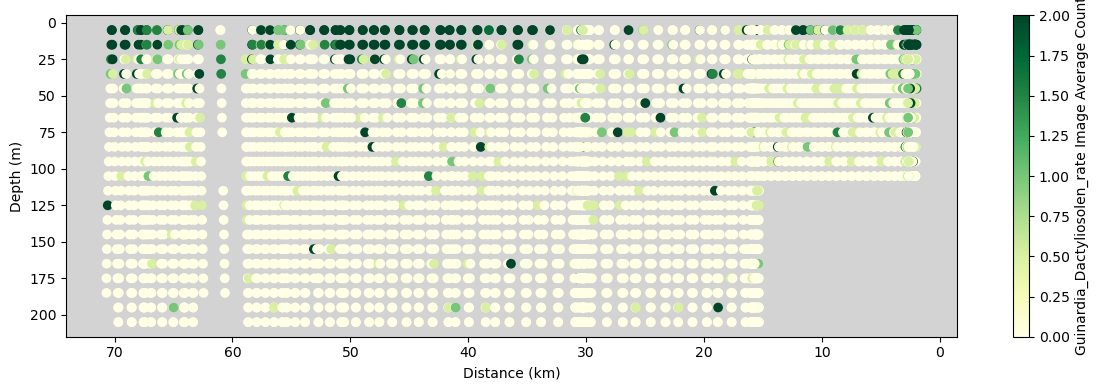

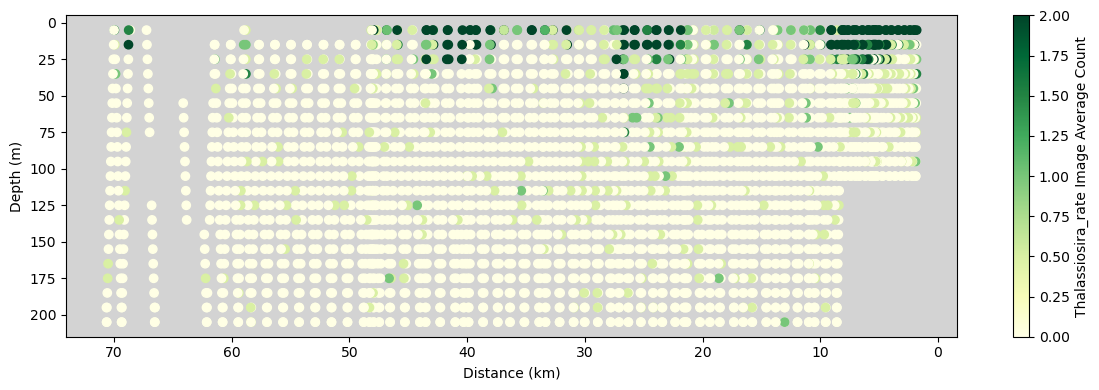

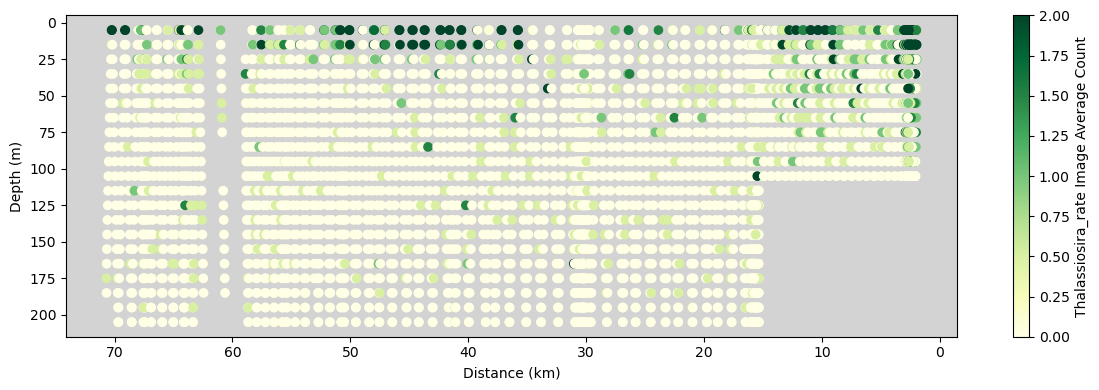

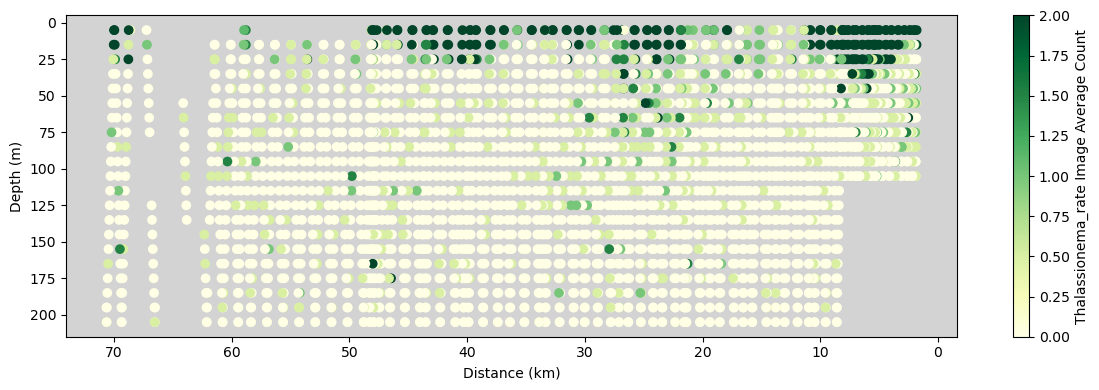

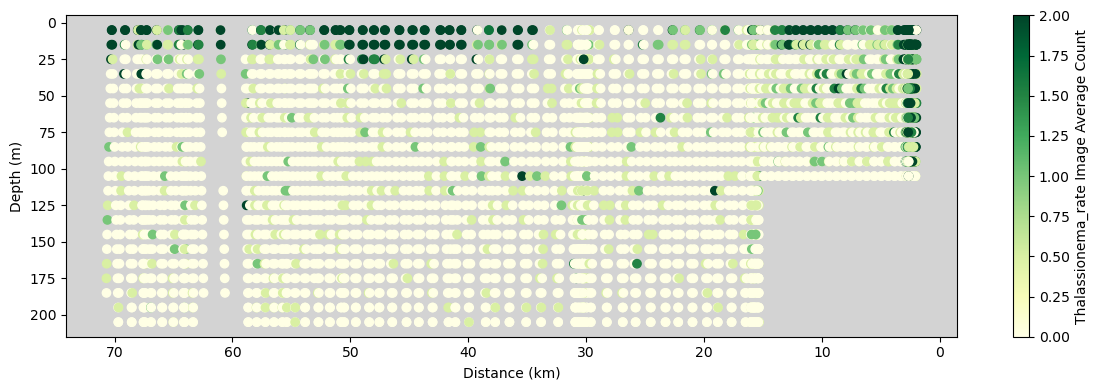

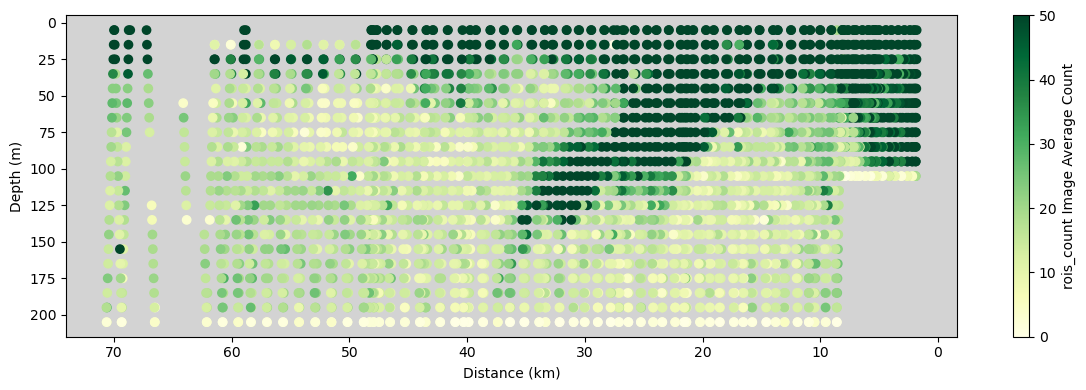

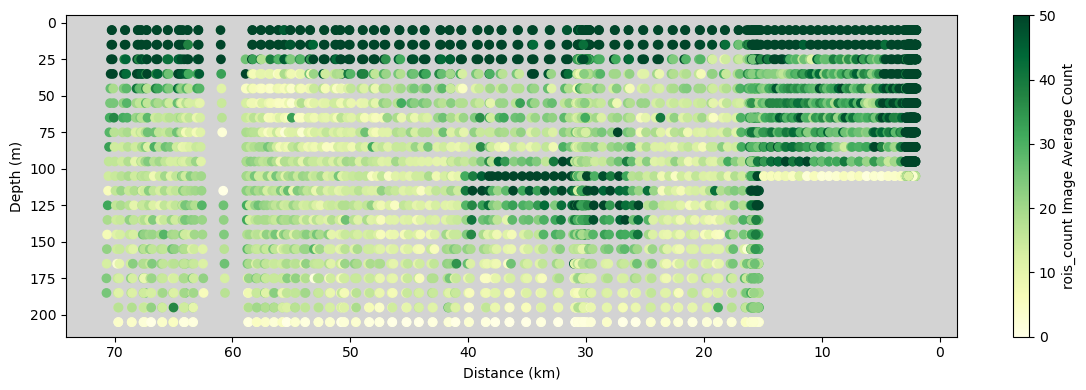

In [64]:
imagelabel=['Akashiwo_rate','Pseudo-nitzschia_rate','Dinoflagellate_rate','Guinardia_Dactyliosolen_rate','Thalassiosira_rate','Thalassionema_rate','rois_count']
icount=np.arange(0,len(imagelabel))


turn = dt.datetime(2025,4,16,9,40)
out_trans = binned.query("start_time < @turn")
in_trans = binned.query("start_time >= @turn")

for iout in icount:
    label=imagelabel[iout]
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_facecolor('lightgray')
    sc = ax.scatter(
           out_trans.distance_km,out_trans['depth_bin_center'], c=out_trans[label],cmap='YlGn')
    #sc.set_clim(0, 2)
#fig, ax = plt.subplots(figsize=(12, 4))

#label = "Detritus"
#label = "Pseudo-nitzschia"
#label = "Chaetoceros"
#label = "Ciliate"
#label = "Medium_pennate"
#sc=ax.pcolor(out_trans.distance_km,out_trans['depth'],out_trans[label])
#sc = ax.scatter(
#    out_trans.distance_km,out_trans['depth_bin_center'], c=out_trans[label])
#    #out_trans.distance_km,out_trans['depth'], c=out_trans[label])
    cmax=np.ceil(out_trans[label].max())
    cmin=np.floor(out_trans[label].min())
    #sc.set_clim(cmin, cmax)
    if iout==2:
        sc.set_clim(0, 10)
    else:
        sc.set_clim(0, 2)
    if iout==6:
        sc.set_clim(0,50)
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Distance (km)')
    if iout==6:
        plt.colorbar(sc, ax=ax, label=imagelabel[iout]+' Image Average Count')
    else:
        plt.colorbar(sc, ax=ax, label=imagelabel[iout]+' Image Average Count')

#plt.colorbar(sc, label=label)
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
    plt.tight_layout()
#plt.savefig(fig_dir / 'April2025_MP_outbound_distance.png', dpi=300, bbox_inches='tight')
    outname1='April2025_'+imagelabel[iout]+'_outbound_distance_rate.png'
    plt.savefig(fig_dir / outname1, dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'April2025_PN_outbound_distance.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'April2025_detritus_outbound_distance.png', dpi=300, bbox_inches='tight')

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_facecolor('lightgray')
    sc = ax.scatter(
        in_trans.distance_km,in_trans['depth_bin_center'], c=in_trans[label],cmap='YlGn')
    #in_trans.distance_km,in_trans['depth'], c=in_trans[label])
    cmax=np.ceil(in_trans[label].max())
    cmin=np.floor(in_trans[label].min())
    #sc.set_clim(cmin, cmax)
    if iout==2:
        sc.set_clim(0, 10)
    else:
        sc.set_clim(0, 2)
    if iout==6:
        sc.set_clim(0,50)
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Distance (km)')
    if iout==6:
        plt.colorbar(sc, ax=ax, label=imagelabel[iout]+' Image Average Count')
    else:        
        plt.colorbar(sc, ax=ax, label=imagelabel[iout]+' Image Average Count')
#plt.colorbar(sc, ax=ax, label='PN Image Count (images/s/2 meter)')

#plt.colorbar(sc, label=label)
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
    plt.tight_layout()
#plt.savefig(fig_dir / 'April2025_MP_inbound_distance.png', dpi=300, bbox_inches='tight')
    outname='April2025_'+imagelabel[iout]+'_inbound_distance_rate.png'
    plt.savefig(fig_dir /outname, dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'April2025_PN_inbound_distance.png', dpi=300, bbox_inches='tight')    
#plt.savefig(fig_dir / 'April2025_detritus_inbound_distance.png', dpi=300, bbox_inches='tight')    


In [ ]:
out_trans.head()

In [ ]:
type(out_trans)

In [ ]:
out_trans.to_csv('April2025_outbound_transect_PO_and_classified_sum_withNaN.csv')
#out_trans.to_parquet('April2025_outbound_bined_labeled.parquet')
#binned.to_parquet('April2025_bined_and_labeled_model20251009_filtered_window5_sumvmean_withNaN.parquet')

In [ ]:
out_trans['rois_count']

In [ ]:
uid=np.unique(out_trans['cast_id'])
#lp=np.arange(0,5)
bins_d=out_trans['depth_bin_center'].values
lp=np.arange(0,len(uid))
#print(bins_d.max(),bins_d.min())
phase=out_trans['phase'].values
castid=out_trans['cast_id'].values
label='Pseudo-nitzschia'
#label='Detritus'
species=out_trans[label].values
distance=out_trans['distance_km'].values
dvec=np.arange(2.5,203.5,5)
# number of profiles up and down
nsp=np.zeros((len(dvec),len(2*lp)))
nsp=nsp*np.nan
ndp=np.zeros((len(dvec),len(lp)))
ndp=ndp*np.nan
ndd=np.zeros((len(dvec),len(lp)))
ndd=ndd*np.nan
for i in lp:
    index=np.where((castid==uid[i]) & (phase=='down'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])
    index=np.where((castid==uid[i]) & (phase=='up'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])

In [ ]:
uid=np.unique(in_trans['cast_id'])
#lp=np.arange(0,5)
bins_d=in_trans['depth_bin_center'].values
lp=np.arange(0,len(uid))
#print(bins_d.max(),bins_d.min())
phase=in_trans['phase'].values
castid=in_trans['cast_id'].values
#label='Pseudo-nitzschia'
label='Detritus'
species=in_trans[label].values
distance=in_trans['distance_km'].values
dvec=np.arange(2.5,203.5,5)
# number of profiles up and down
nsp=np.zeros((len(dvec),len(2*lp)))
nsp=nsp*np.nan
ndp=np.zeros((len(dvec),len(lp)))
ndp=ndp*np.nan
ndd=np.zeros((len(dvec),len(lp)))
ndd=ndd*np.nan
for i in lp:
    index=np.where((castid==uid[i]) & (phase=='down'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])
    index=np.where((castid==uid[i]) & (phase=='up'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])

In [ ]:
fig,ax=plt.subplots()
plot=ax.pcolor(ndd,-ndp,nsp,cmap='plasma',vmin=0,vmax=4)
#ax.invert_yaxis()
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')
#plot.set_array(nsp.flatten())
fig.colorbar(plot,ax=ax)
#plt.tight_layout() 



In [ ]:
from matplotlib import dates as mdates
from scipy.interpolate import griddata

# --- 0) Your input long-form data ---
# binned columns needed: start_time (datetime-like), depth (m), sigma_theta (kg/m^3)
binned_df = binned.dropna(subset=["start_time", "depth_bin_center", "sigma_theta"]).copy()
binned_df["start_time"] = pd.to_datetime(binned_df["start_time"])

# --- 1) Build a regular target grid (you pick the resolution) ---
# time grid: from min to max with, e.g., 2-minute spacing (adjust as needed)
tmin, tmax = binned_df["start_time"].min(), binned_df["start_time"].max()
time_grid = pd.date_range(tmin, tmax, freq="60min")  # change interval as appropriate

# depth grid: e.g., 0.5 m spacing from shallowest to deepest observed
zmin, zmax = binned_df["depth_bin_center"].min(), binned_df["depth_bin_center"].max()
depth_grid = np.arange(np.floor(zmin), np.ceil(zmax) + 1, 10)

# Convert times to Matplotlib date numbers (floats) for contouring
t_num = mdates.date2num(binned_df["start_time"].to_numpy())
Tg_num = mdates.date2num(time_grid.to_pydatetime())


# --- 2) Interpolate onto the grid ---
# Prepare source points and values
points = np.column_stack([t_num, binned_df["depth_bin_center"].to_numpy()])
values = binned_df["sigma_theta"].to_numpy()

# Target mesh
TTg, ZZg = np.meshgrid(Tg_num, depth_grid)

# Interpolate; 'linear' is typical; fall back to 'nearest' for gaps
SS = griddata(points, values, (TTg, ZZg), method="linear")
# SS   = griddata(points, values, (TTg, ZZg), method="nearest")

# Fill holes left by linear interpolation with nearest-neighbor
# SS = np.where(np.isnan(SS_linear), SS_near, SS_linear)

# Optional: mask impossible ranges or leave NaN to avoid misleading contours
# SS[(SS < 10) | (SS > 40)] = np.nan  # example sanity check

# --- 3) Choose contour levels ---
# You can pick a fixed range or use percentiles to adapt to each dataset
valid = SS[np.isfinite(SS)]
vmin, vmax = np.percentile(valid, [5, 95]) if valid.size else (24, 27)
levels = np.arange(np.floor(vmin*10)/10, np.ceil(vmax*10)/10 + 1e-9, 0.2)  # every 0.2 kg/m^3
levels = [25.8,26,26.2]

# --- 4) Plot: base scatter (optional) + isopycnal contours ---
fig, ax = plt.subplots(figsize=(12, 6))

# # (Optional) show original points
sc = ax.scatter(binned_df["start_time"], binned_df["depth_bin_center"], c=binned_df["Pseudo-nitzschia"], s=10, cmap="viridis",vmin=0,vmax=2)
plt.colorbar(sc, ax=ax, label="Normalized Image Count")

# Contours (isopycnals) from gridded field
CS = ax.contour(mdates.num2date(TTg), ZZg, SS, levels=levels, colors="w", linewidths=2)
ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")  # label lines

# Format axes
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()